# Heart disease analysis

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Models to be used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Import KMedoids
from sklearn_extra.cluster import KMedoids

# Metrics
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

2024-10-10 21:22:36,986 INFO: generated new fontManager


# 1. Read the dataset from CSV file

In [2]:
df = pd.read_csv('complete_case_data.csv')

In [3]:
# Display the first few rows
df.head()

,age,gender,chest_pain_type,serum_cholesterol,high_fasting_blood_sugar,resting_ecg_results,max_heart_rate,exercise_induced_angina,st_depression,has_hypertension,cigarettes_per_day,years_smoking,family_history_cad,resting_heart_rate,heart_disease_diagnosis
0,63,Male,Typical Angina,233.0,True,Left Ventricular Hypertrophy,150.0,False,2.3,1.0,50.0,20.0,True,60.0,False
1,67,Male,Asymptomatic,286.0,False,Left Ventricular Hypertrophy,108.0,True,1.5,1.0,40.0,40.0,True,64.0,True
2,67,Male,Asymptomatic,229.0,False,Left Ventricular Hypertrophy,129.0,True,2.6,1.0,20.0,35.0,True,78.0,True
3,37,Male,Non-Anginal Pain,250.0,False,Normal,187.0,False,3.5,0.0,0.0,0.0,True,84.0,False
4,41,Female,Atypical Angina,204.0,False,Left Ventricular Hypertrophy,172.0,False,1.4,1.0,0.0,0.0,True,71.0,False


# 2. Analytical Diagnostics
## Checking for Missing Values

In [4]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 age                         0
gender                      0
chest_pain_type             0
serum_cholesterol           0
high_fasting_blood_sugar    0
resting_ecg_results         0
max_heart_rate              0
exercise_induced_angina     0
st_depression               0
has_hypertension            0
cigarettes_per_day          0
years_smoking               0
family_history_cad          0
resting_heart_rate          0
heart_disease_diagnosis     0
dtype: int64


## Descriptive Statistics

In [5]:
desc_stats = df.describe()
desc_stats

,age,serum_cholesterol,max_heart_rate,st_depression,has_hypertension,cigarettes_per_day,years_smoking,resting_heart_rate
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,55.896465,228.366162,140.916667,1.086869,0.608586,18.224747,17.810606,73.075758
std,8.962475,81.405749,26.153599,1.131071,0.488684,18.516568,16.070950,13.130863
min,29.000000,0.000000,69.000000,-0.500000,0.000000,0.000000,0.000000,37.000000
25%,50.000000,204.000000,120.000000,0.000000,0.000000,0.000000,0.000000,64.000000
50%,57.000000,234.500000,143.000000,0.950000,1.000000,20.000000,20.000000,72.000000
75%,62.000000,270.000000,161.000000,1.800000,1.000000,30.000000,30.000000,82.000000
max,77.000000,564.000000,202.000000,6.200000,1.000000,99.000000,54.000000,119.000000


## Data Types and Unique Values

In [6]:
data_types = df.dtypes
print("Data types of each column:\n", data_types)

Data types of each column:
 age                           int64
gender                       object
chest_pain_type              object
serum_cholesterol           float64
high_fasting_blood_sugar       bool
resting_ecg_results          object
max_heart_rate              float64
exercise_induced_angina        bool
st_depression               float64
has_hypertension            float64
cigarettes_per_day          float64
years_smoking               float64
family_history_cad             bool
resting_heart_rate          float64
heart_disease_diagnosis        bool
dtype: object


In [7]:
categorical_features = [
    'gender', 'chest_pain_type', 'high_fasting_blood_sugar',
    'resting_ecg_results', 'exercise_induced_angina',
    'has_hypertension', 'family_history_cad', 'heart_disease_diagnosis'
]

for col in categorical_features:
    unique_vals = df[col].unique()
    print(f"Unique values in {col}: {unique_vals}")

## Data Distributions
numerical_features = [
    'age', 'serum_cholesterol', 'max_heart_rate', 'st_depression',
    'cigarettes_per_day', 'years_smoking', 'resting_heart_rate'
]

Unique values in gender: ['Male' 'Female']
Unique values in chest_pain_type: ['Typical Angina' 'Asymptomatic' 'Non-Anginal Pain' 'Atypical Angina']
Unique values in high_fasting_blood_sugar: [ True False]
Unique values in resting_ecg_results: ['Left Ventricular Hypertrophy' 'Normal' 'ST-T Wave Abnormality']
Unique values in exercise_induced_angina: [False  True]
Unique values in has_hypertension: [1. 0.]
Unique values in family_history_cad: [ True False]
Unique values in heart_disease_diagnosis: [False  True]


## Histograms

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


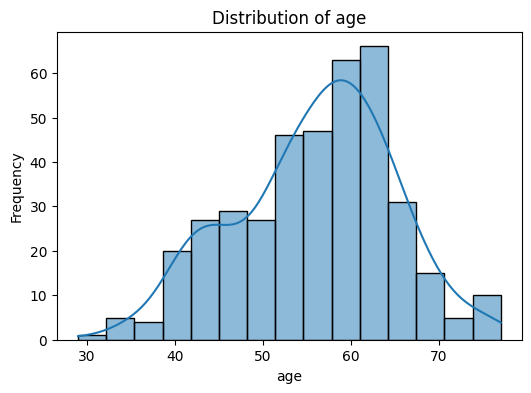

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


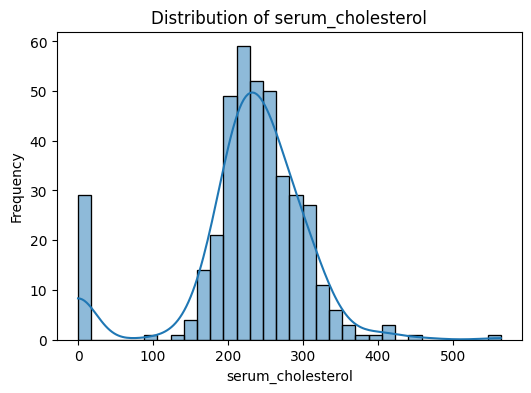

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


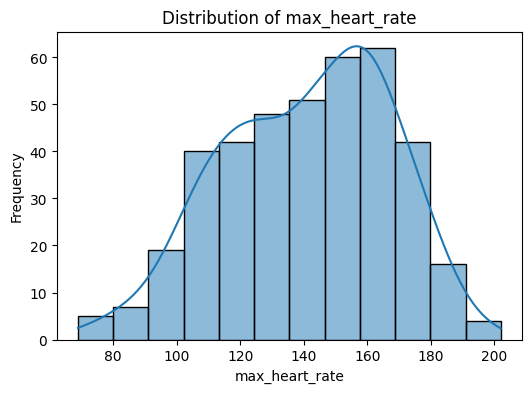

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


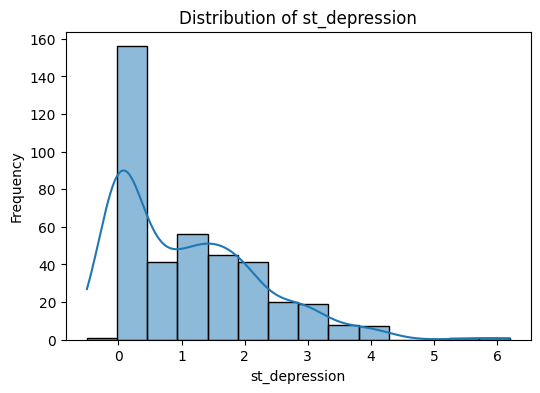

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


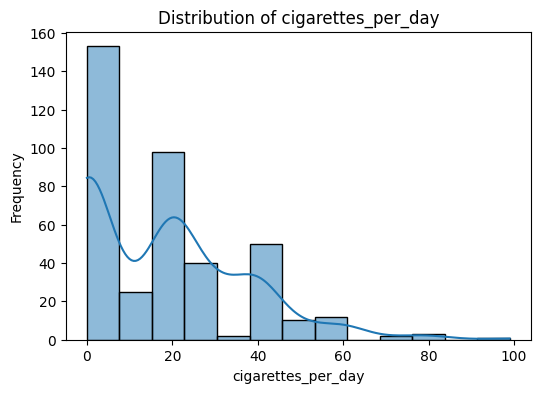

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


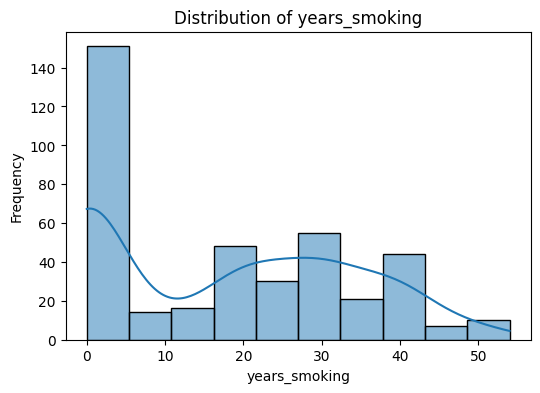

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


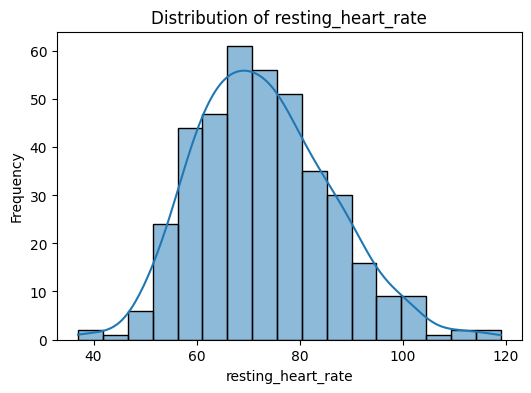

In [8]:
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

## Outlier Detection

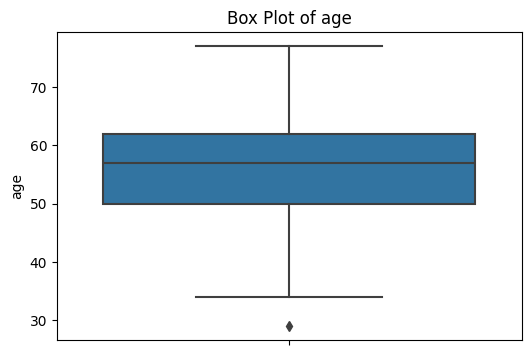

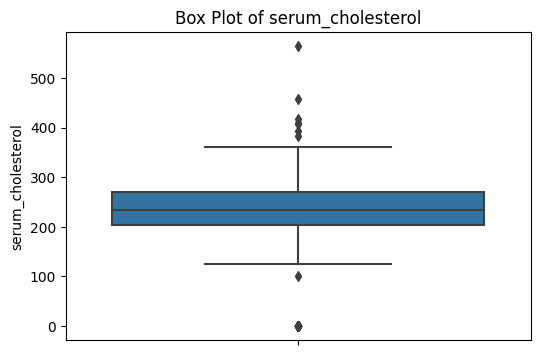

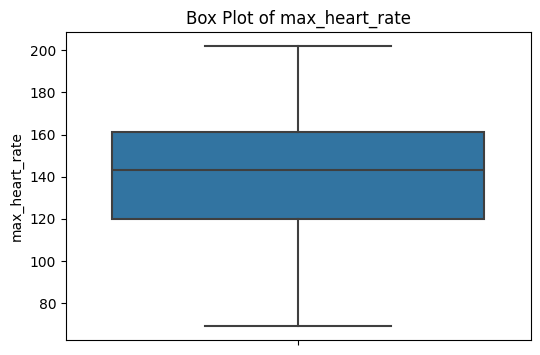

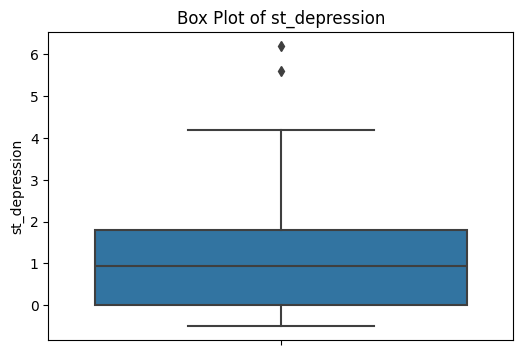

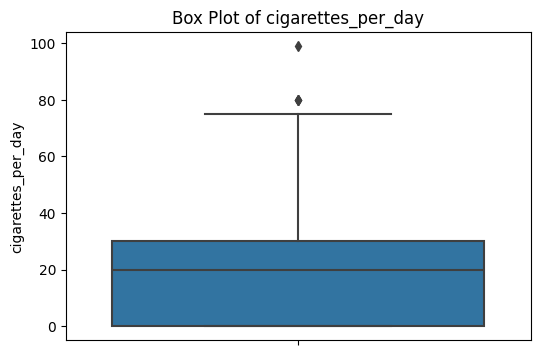

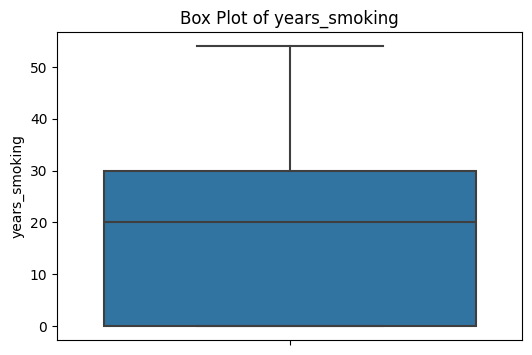

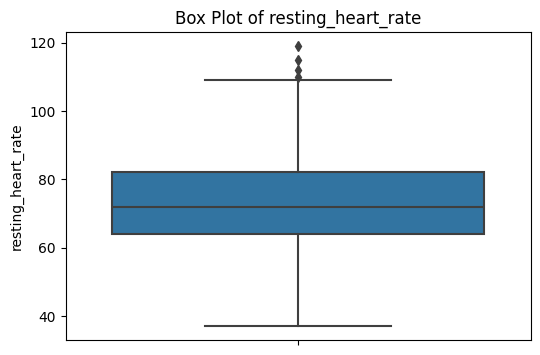

In [9]:
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.show()

## Correlation Matrix

In [10]:
corr_matrix = df[numerical_features + ['heart_disease_diagnosis']].corr()
corr_matrix

,age,serum_cholesterol,max_heart_rate,st_depression,cigarettes_per_day,years_smoking,resting_heart_rate,heart_disease_diagnosis
age,1.000000,0.030282,-0.396998,0.192938,-0.118086,0.113584,-0.087487,0.252511
serum_cholesterol,0.030282,1.000000,0.158090,-0.001256,-0.154073,-0.119078,0.175932,-0.041093
max_heart_rate,-0.396998,0.158090,1.000000,-0.216431,-0.018425,-0.119641,0.417687,-0.408297
st_depression,0.192938,-0.001256,-0.216431,1.000000,-0.060383,-0.012923,-0.120856,0.372578
cigarettes_per_day,-0.118086,-0.154073,-0.018425,-0.060383,1.000000,0.603468,-0.022988,0.082922
years_smoking,0.113584,-0.119078,-0.119641,-0.012923,0.603468,1.000000,-0.039773,0.127743
resting_heart_rate,-0.087487,0.175932,0.417687,-0.120856,-0.022988,-0.039773,1.000000,-0.165763
heart_disease_diagnosis,0.252511,-0.041093,-0.408297,0.372578,0.082922,0.127743,-0.165763,1.000000


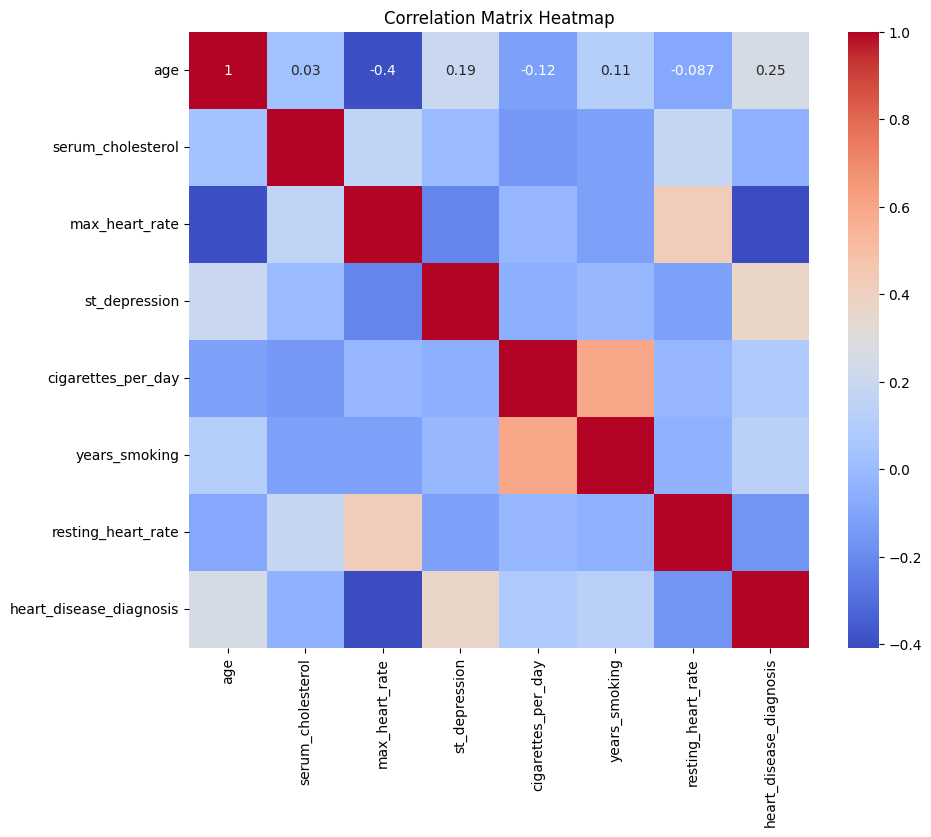

In [11]:
## Heatmap Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

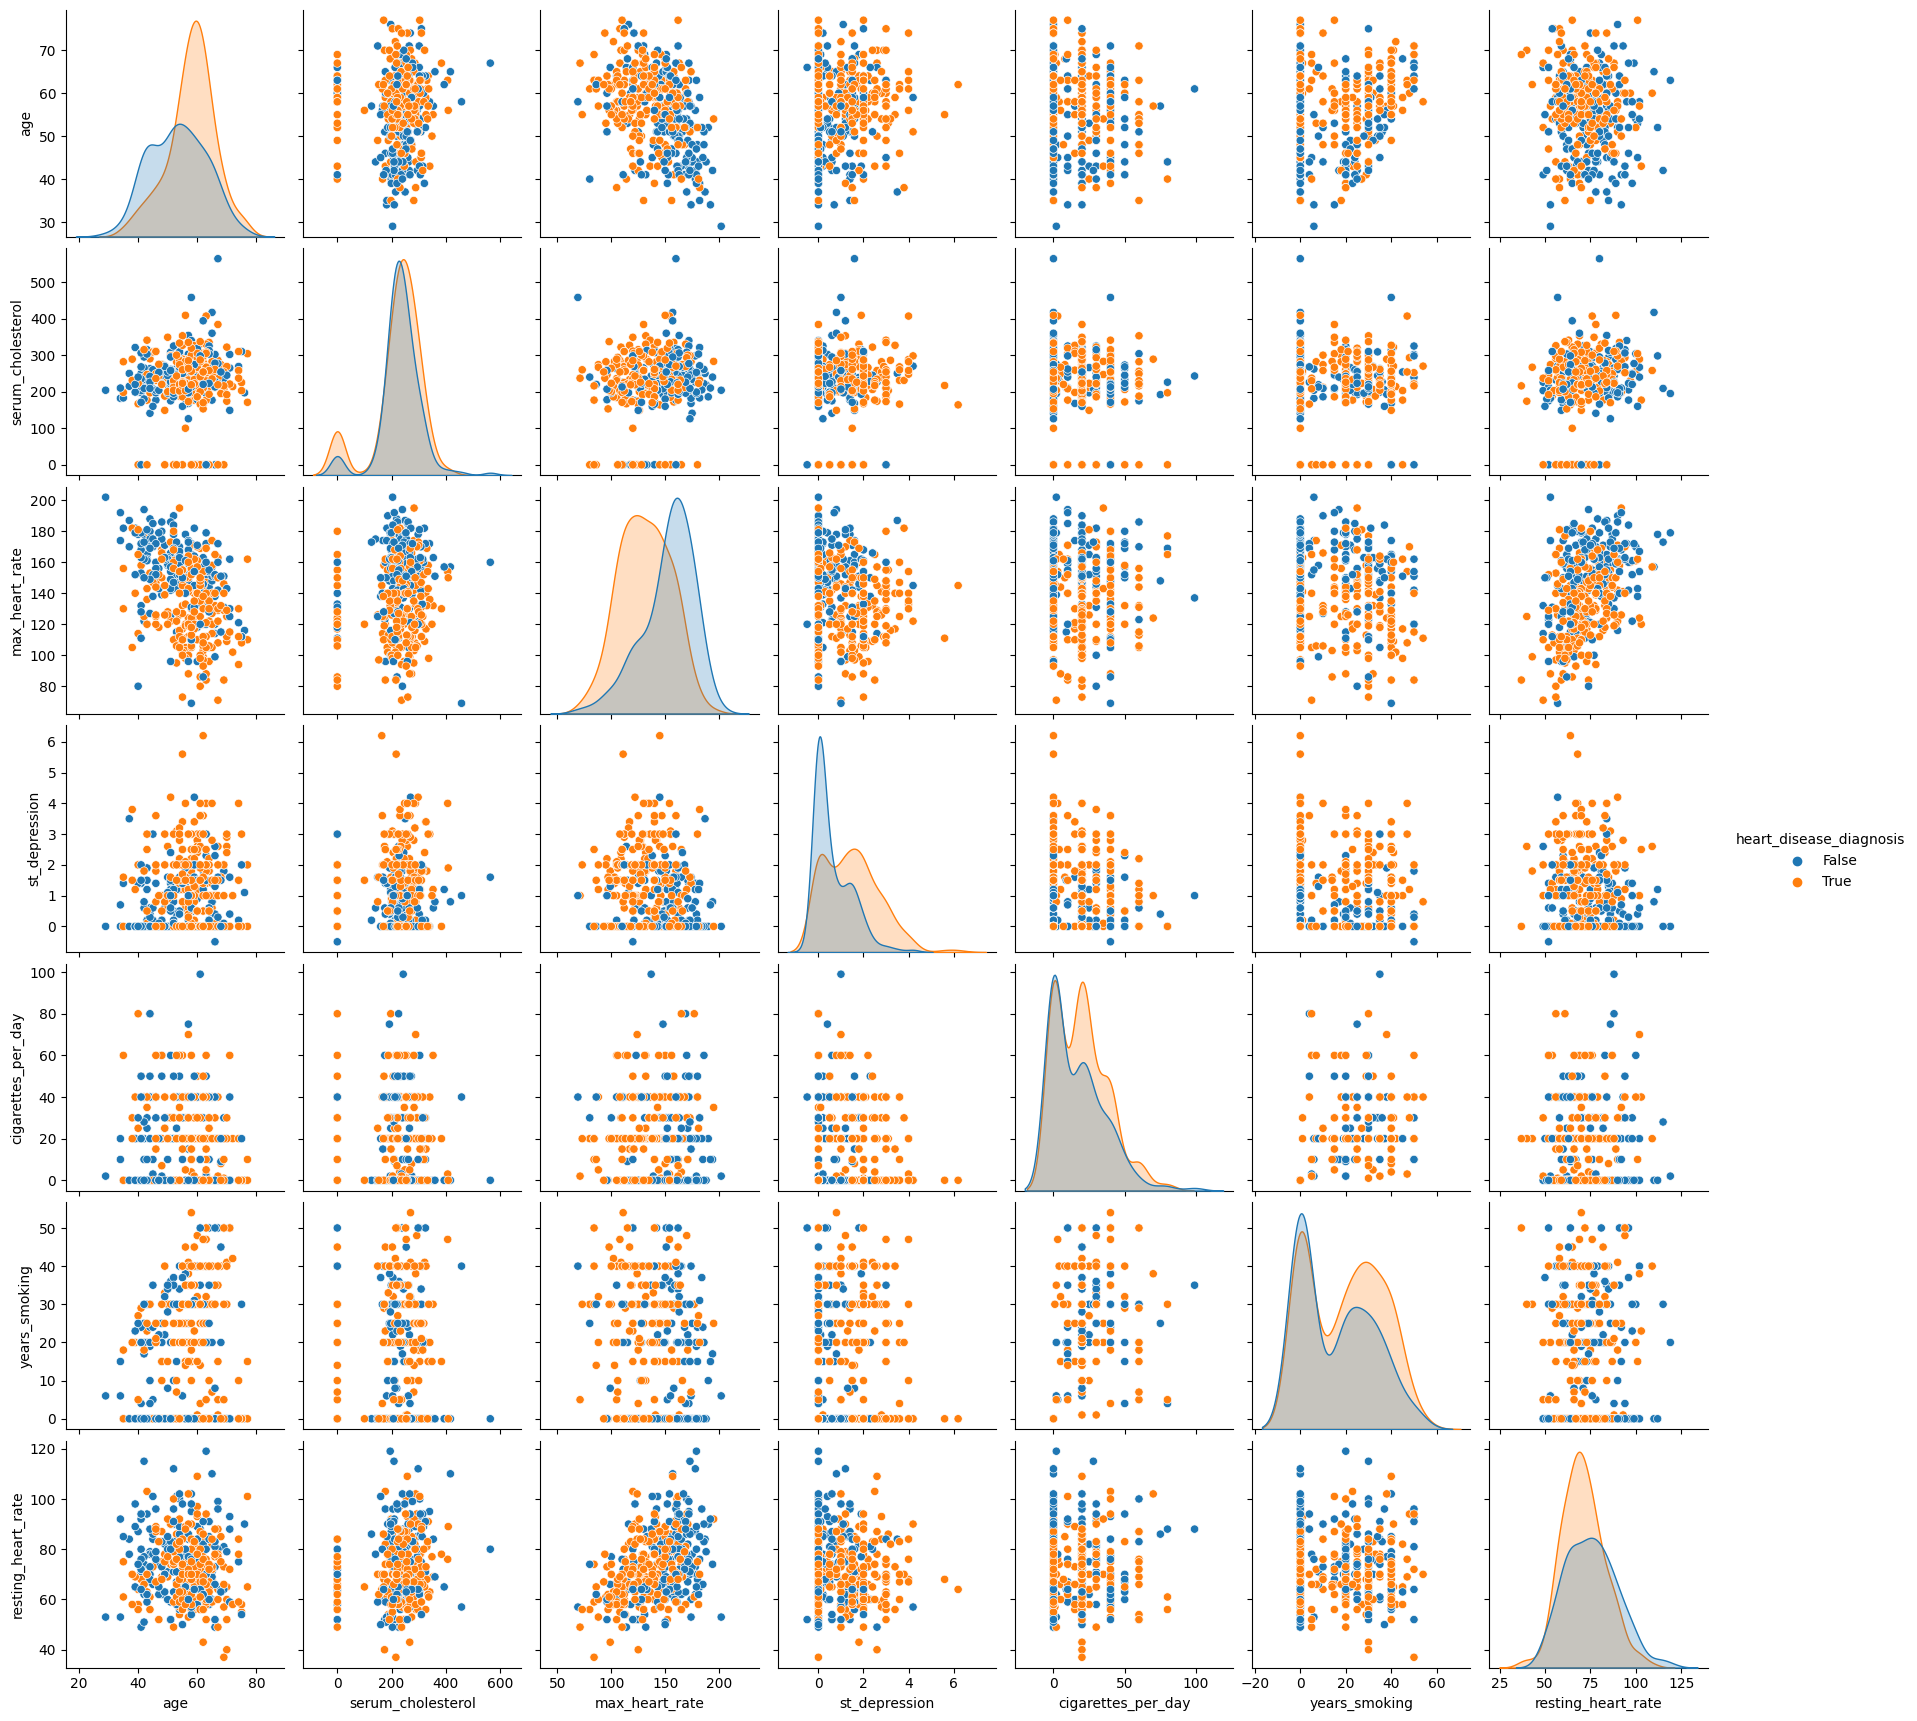

In [12]:
## Pairplot Analysis
sns.pairplot(df[numerical_features + ['heart_disease_diagnosis']], hue='heart_disease_diagnosis')
plt.show()

Cramér's V Correlation Matrix:
                            gender  chest_pain_type  high_fasting_blood_sugar  \
gender                    0.000000         0.178599                  0.083887   
chest_pain_type           0.178599         0.000000                  0.000000   
high_fasting_blood_sugar  0.083887         0.000000                  0.000000   
resting_ecg_results       0.159314         0.112233                  0.138778   
exercise_induced_angina   0.233657         0.409997                  0.000000   
has_hypertension          0.056337         0.000000                  0.000000   
family_history_cad        0.087787         0.000000                  0.000000   
heart_disease_diagnosis   0.348745         0.473879                  0.079163   

                          resting_ecg_results  exercise_induced_angina  \
gender                               0.159314                 0.233657   
chest_pain_type                      0.112233                 0.409997   
high_fasting_bloo

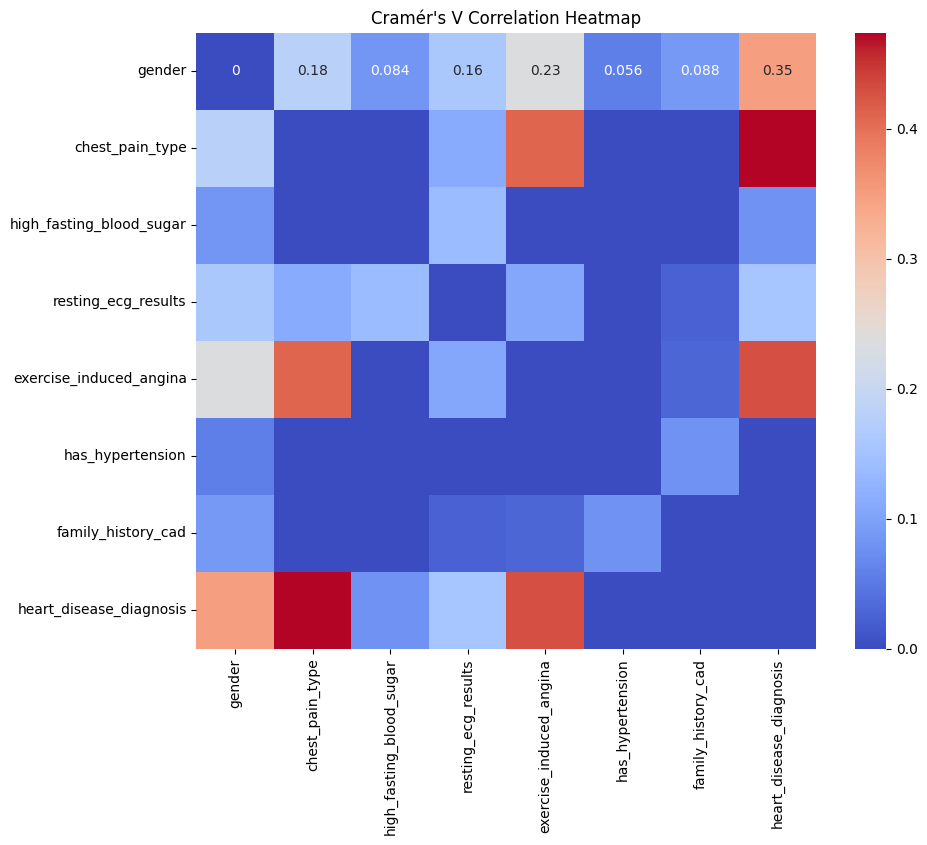

In [13]:
# Include the target variable
categorical_features_with_target = categorical_features

from scipy.stats import chi2_contingency
import itertools

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r,k = confusion_matrix.shape
    with np.errstate(divide='ignore', invalid='ignore'):
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        denom = min((kcorr-1), (rcorr-1))
        if denom == 0:
            return np.nan
        else:
            return np.sqrt(phi2corr / denom)

# Compute Cramér's V matrix
cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_features_with_target), len(categorical_features_with_target))), 
                                index=categorical_features_with_target, columns=categorical_features_with_target)

for col1, col2 in itertools.combinations(categorical_features_with_target, 2):
    cv = cramers_v(df[col1], df[col2])
    cramers_v_matrix.loc[col1, col2] = cv
    cramers_v_matrix.loc[col2, col1] = cv

# Display the Cramér's V matrix
print("Cramér's V Correlation Matrix:")
print(cramers_v_matrix)

# Plot the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm')
plt.title("Cramér's V Correlation Heatmap")
plt.show()


# 3. Data Preprocessing for machine learning 

In [14]:
# Define categorical and numerical features
categorical_features = [
    'gender', 'chest_pain_type', 'high_fasting_blood_sugar',
    'resting_ecg_results', 'exercise_induced_angina',
    'has_hypertension', 'family_history_cad'
]

numerical_features = [
    'age', 'serum_cholesterol', 'max_heart_rate', 'st_depression',
    'cigarettes_per_day', 'years_smoking', 'resting_heart_rate'
]

# Convert target variable to binary numerical values
df['heart_disease_diagnosis'] = df['heart_disease_diagnosis'].map({False: 0, True: 1})

# Separate features and target variable
X = df.drop('heart_disease_diagnosis', axis=1)
y = df['heart_disease_diagnosis']

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Split data into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Fit the preprocessor on the training data and transform
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Get feature names after preprocessing
cat_transformer = preprocessor.named_transformers_['cat']
cat_feature_names = cat_transformer.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(cat_feature_names)


# 4. Modeling and Hyperparameter Tuning

### We define a dictionary models containing the 10 models along with their hyperparameter grids.
#### The models included are:
 - Unsupervised Clustering with KMeans
 - Unsupervised Clustering with KMedoids
 - Logistic Regression
 - Random Forest
 - XGBoost
 - K-Nearest Neighbors
 - Support Vector Machine
 - Decision Tree
 - Naive Bayes
 - Gradient Boosting Classifier
 - AdaBoost Classifier
 - Extra Trees Classifier
 
For each model, we perform hyperparameter tuning using GridSearchCV.
If a model does not have hyperparameters to tune (e.g., Naive Bayes), we use the default parameters.
We store the best estimator and its performance for each model.



--- Unsupervised Clustering with KMeans ---

For n_clusters = 2, the average silhouette_score is : 0.1481
For n_clusters = 3, the average silhouette_score is : 0.1367
For n_clusters = 4, the average silhouette_score is : 0.1269
For n_clusters = 5, the average silhouette_score is : 0.1415
For n_clusters = 6, the average silhouette_score is : 0.1350
For n_clusters = 7, the average silhouette_score is : 0.1348
For n_clusters = 8, the average silhouette_score is : 0.1306
For n_clusters = 9, the average silhouette_score is : 0.1249
For n_clusters = 10, the average silhouette_score is : 0.1140


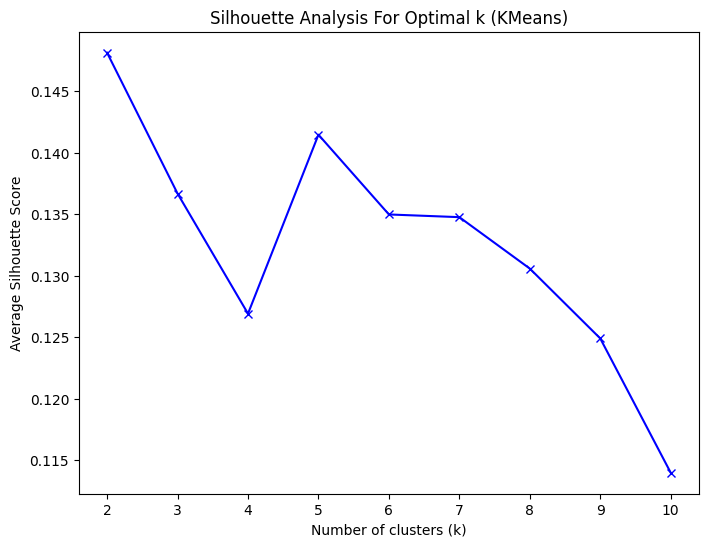


The optimal number of clusters for KMeans is: 2

--- Unsupervised Clustering with KMedoids ---

For n_clusters = 2, the average silhouette_score is : 0.1321
For n_clusters = 3, the average silhouette_score is : 0.1136
For n_clusters = 4, the average silhouette_score is : 0.1228
For n_clusters = 5, the average silhouette_score is : 0.1386
For n_clusters = 6, the average silhouette_score is : 0.1236
For n_clusters = 7, the average silhouette_score is : 0.1049
For n_clusters = 8, the average silhouette_score is : 0.0935
For n_clusters = 9, the average silhouette_score is : 0.0903
For n_clusters = 10, the average silhouette_score is : 0.0878


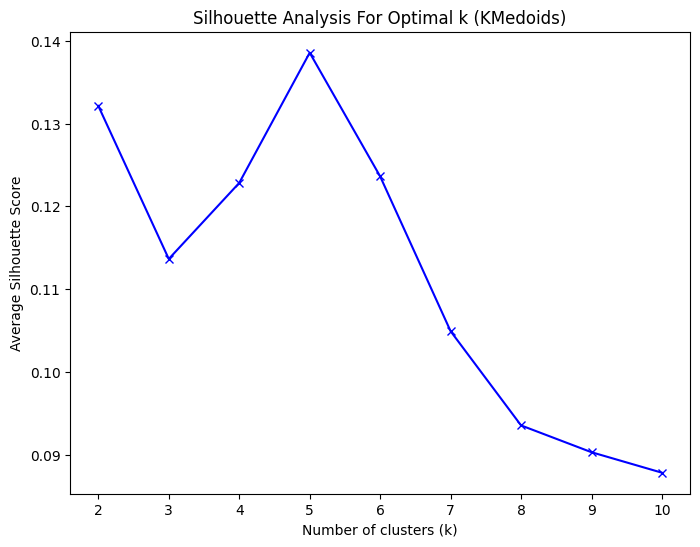


The optimal number of clusters for KMedoids is: 5

--- Visualizing Clusters with Heart Disease Labels ---



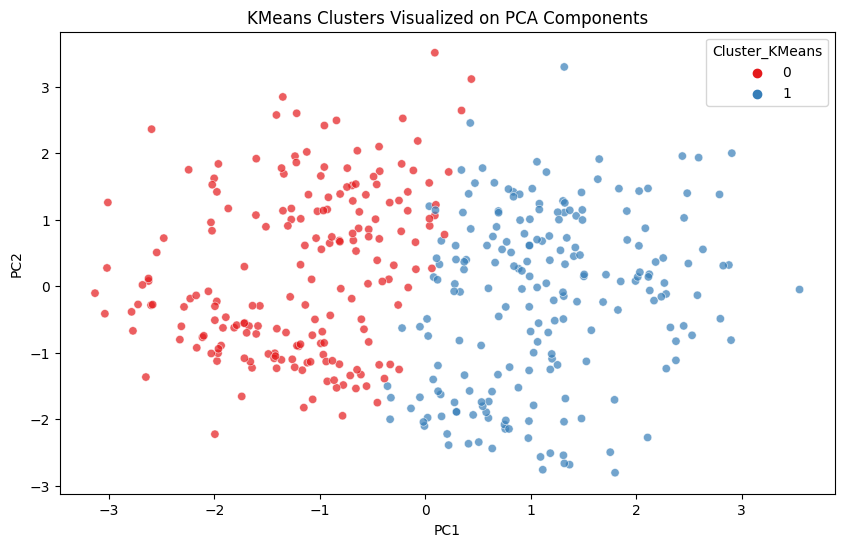

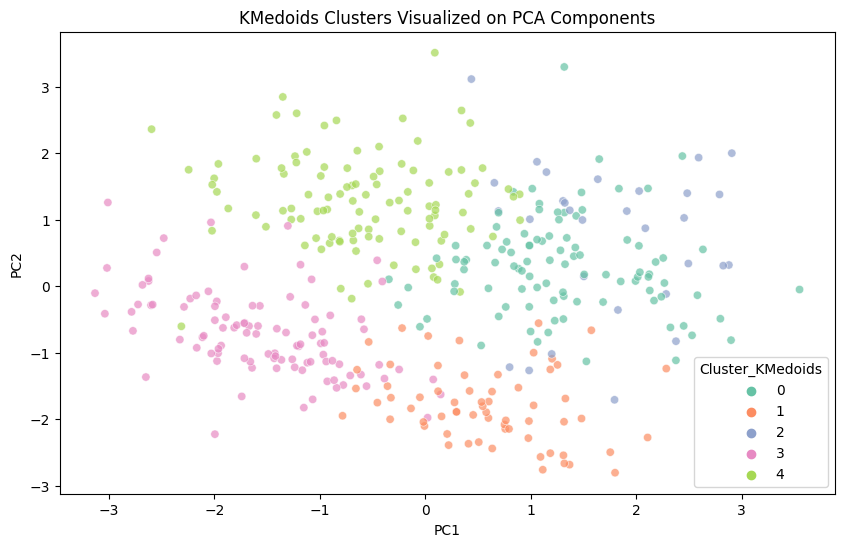

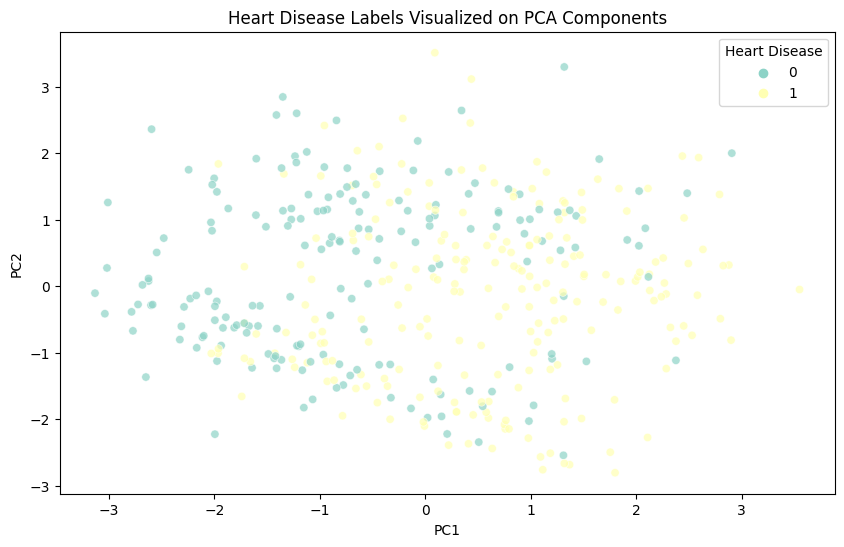


KMeans Cluster vs Heart Disease Crosstabulation:
Heart Disease     0    1
Cluster_KMeans          
0               130   63
1                49  154

KMedoids Cluster vs Heart Disease Crosstabulation:
Heart Disease      0   1
Cluster_KMedoids        
0                 18  79
1                 14  50
2                  9  21
3                 68  32
4                 70  35


In [15]:
X_processed = preprocessor.fit_transform(X)


# 3. Unsupervised Clustering with KMeans

print("\n--- Unsupervised Clustering with KMeans ---\n")

from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using silhouette scores
range_n_clusters = range(2, 11)
silhouette_avg_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k (KMeans)')
plt.show()

# Choose the optimal number of clusters for KMeans
optimal_k_kmeans = range_n_clusters[np.argmax(silhouette_avg_scores)]
print(f"\nThe optimal number of clusters for KMeans is: {optimal_k_kmeans}")

# Perform KMeans clustering with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k_kmeans, random_state=42)
cluster_labels_kmeans = kmeans_optimal.fit_predict(X_processed)

# 4. Unsupervised Clustering with KMedoids

print("\n--- Unsupervised Clustering with KMedoids ---\n")

# Determine the optimal number of clusters using silhouette scores for KMedoids
silhouette_avg_scores_kmedoids = []

for n_clusters in range_n_clusters:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42, method='pam')
    cluster_labels = kmedoids.fit_predict(X_processed)
    silhouette_avg = silhouette_score(X_processed, cluster_labels)
    silhouette_avg_scores_kmedoids.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg:.4f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_avg_scores_kmedoids, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis For Optimal k (KMedoids)')
plt.show()

# Choose the optimal number of clusters for KMedoids
optimal_k_kmedoids = range_n_clusters[np.argmax(silhouette_avg_scores_kmedoids)]
print(f"\nThe optimal number of clusters for KMedoids is: {optimal_k_kmedoids}")

# Perform KMedoids clustering with the optimal number of clusters
kmedoids_optimal = KMedoids(n_clusters=optimal_k_kmedoids, random_state=42, method='pam')
cluster_labels_kmedoids = kmedoids_optimal.fit_predict(X_processed)

# Add the cluster labels to the DataFrame
df['Cluster_KMeans'] = cluster_labels_kmeans
df['Cluster_KMedoids'] = cluster_labels_kmedoids

# 5. Visualize Clusters with Heart Disease Labels

print("\n--- Visualizing Clusters with Heart Disease Labels ---\n")

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster_KMeans': cluster_labels_kmeans,
    'Cluster_KMedoids': cluster_labels_kmedoids,
    'Heart Disease': y
})

# Plot the KMeans clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='Cluster_KMeans', palette='Set1', alpha=0.7)
plt.title('KMeans Clusters Visualized on PCA Components')
plt.show()

# Plot the KMedoids clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='Cluster_KMedoids', palette='Set2', alpha=0.7)
plt.title('KMedoids Clusters Visualized on PCA Components')
plt.show()

# Plot the actual heart disease labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='Heart Disease', palette='Set3', alpha=0.7)
plt.title('Heart Disease Labels Visualized on PCA Components')
plt.show()

# Analyze how heart disease labels fall within KMeans clusters
cluster_analysis_kmeans = pd.crosstab(df['Cluster_KMeans'], df['heart_disease_diagnosis'], rownames=['Cluster_KMeans'], colnames=['Heart Disease'])
print("\nKMeans Cluster vs Heart Disease Crosstabulation:")
print(cluster_analysis_kmeans)

# Analyze how heart disease labels fall within KMedoids clusters
cluster_analysis_kmedoids = pd.crosstab(df['Cluster_KMedoids'], df['heart_disease_diagnosis'], rownames=['Cluster_KMedoids'], colnames=['Heart Disease'])
print("\nKMedoids Cluster vs Heart Disease Crosstabulation:")
print(cluster_analysis_kmedoids)


In [15]:
# Define a dictionary to hold models and their parameter grids
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1]
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'Support Vector Machine': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {
            # GaussianNB doesn't have hyperparameters to tune
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5]
        }
    }
}

In [16]:
# Dictionary to store the results
model_results = {}
best_estimators = {}

# Perform hyperparameter tuning and evaluation for each model
for model_name, mp in models.items():
    print(f"\nTraining and tuning {model_name}...")
    model = mp['model']
    params = mp['params']
   
    if params:
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        # For models without hyperparameters to tune (e.g., Naive Bayes)
        best_model = model.fit(X_train, y_train)
        best_params = 'Default parameters'
   
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best Parameters: {best_params}")
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
   
    # Store results
    model_results[model_name] = accuracy
    best_estimators[model_name] = best_model


Training and tuning Logistic Regression...
Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.7875
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75        36
           1       0.79      0.84      0.81        44

    accuracy                           0.79        80
   macro avg       0.79      0.78      0.78        80
weighted avg       0.79      0.79      0.79        80


Training and tuning Random Forest...
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Accuracy: 0.7375
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.67      0.70        36
           1       0.74      0.80      0.77        44

    accuracy                           0.74        80
   macro avg       0.74      0.73      0.73        80
weighted avg       0.74      0.74      0.74        80


Training and tunin

# 6. Compare model performance

- We identify the best model based on accuracy.
- We perform feature importance analysis using SHAP values where applicable.
- For tree-based models (e.g., Random Forest, XGBoost), we use shap.TreeExplainer.
- For linear models (e.g., Logistic Regression), we use shap.LinearExplainer.
- For SVM, we use shap.KernelExplainer, but note that this can be computationally intensive.
- If the model has feature_importances_ attribute, we plot the feature importances.
- If the model has coef_ attribute (e.g., Logistic Regression), we plot the coefficients.


Model Performance:
                    Model  Accuracy
6             Naive Bayes    0.8500
8                AdaBoost    0.8250
0     Logistic Regression    0.7875
2                 XGBoost    0.7875
4  Support Vector Machine    0.7750
7       Gradient Boosting    0.7500
1           Random Forest    0.7375
9             Extra Trees    0.7375
3     K-Nearest Neighbors    0.7250
5           Decision Tree    0.6875


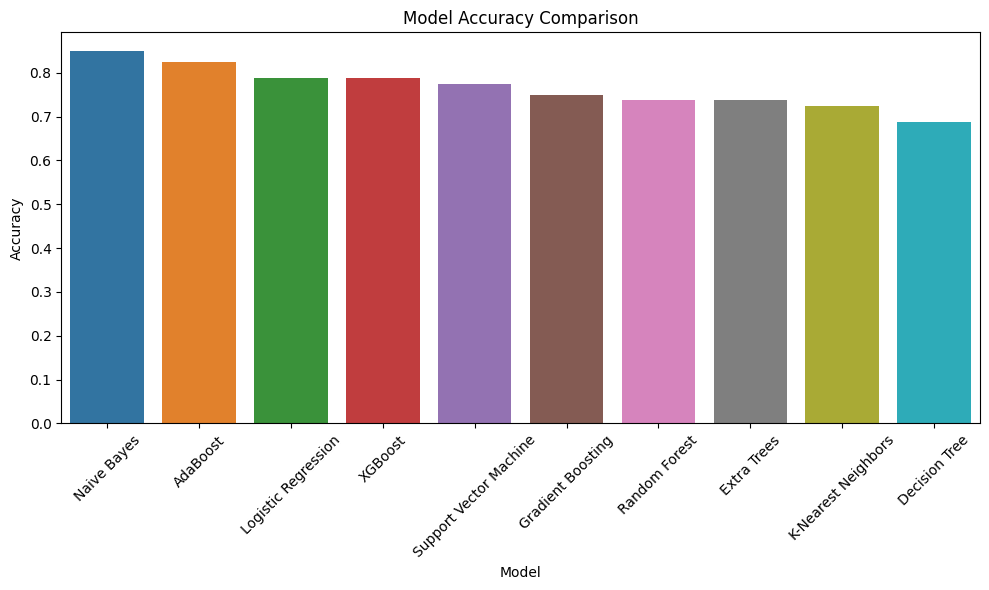

In [17]:
# Convert results to DataFrame
performance = pd.DataFrame(list(model_results.items()), columns=['Model', 'Accuracy'])

# Sort by accuracy
performance = performance.sort_values(by='Accuracy', ascending=False)
print("\nModel Performance:")
print(performance)

# Plotting Model Performance
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='Accuracy', data=performance)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

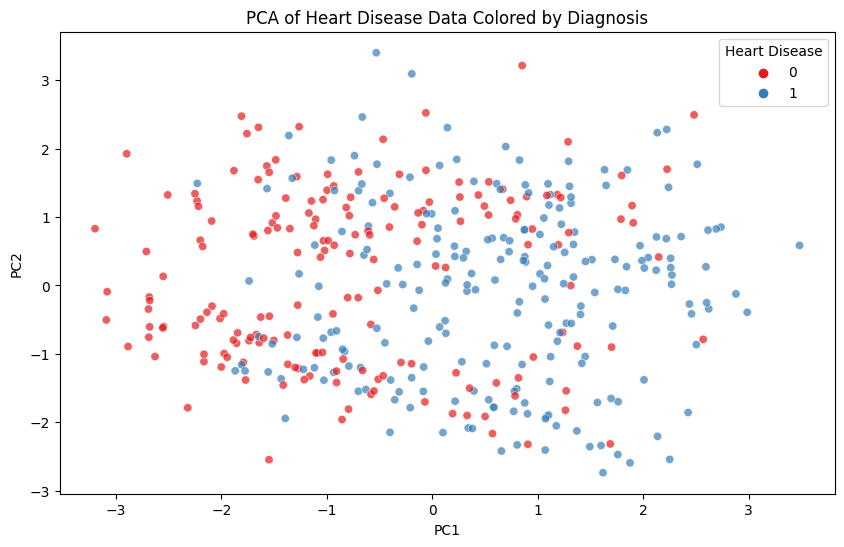

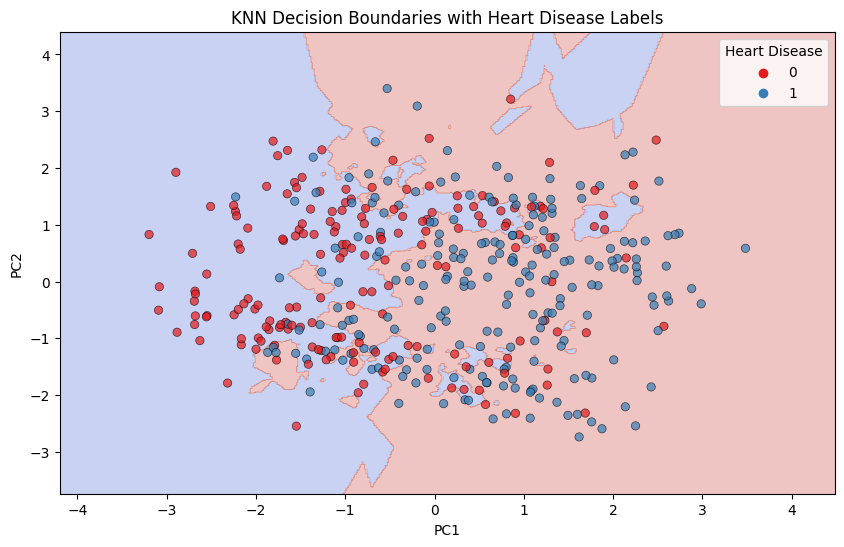

In [19]:
# We will use PCA to reduce dimensions to 2D for visualization

# Combine training and test sets for visualization
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_combined)

# Create a DataFrame for visualization
visualization_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Heart Disease': y_combined
})

# Plot the PCA components colored by heart disease diagnosis
plt.figure(figsize=(10, 6))
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='Heart Disease', palette='Set1', alpha=0.7)
plt.title('PCA of Heart Disease Data Colored by Diagnosis')
plt.show()

# Train KNN on the PCA-transformed data
knn_visual = KNeighborsClassifier(n_neighbors=5)
knn_visual.fit(X_pca, y_combined)

# Create a mesh grid for plotting decision boundaries
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on the mesh grid
Z = knn_visual.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries with data points
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(data=visualization_df, x='PC1', y='PC2', hue='Heart Disease', palette='Set1', alpha=0.7, edgecolor='k')
plt.title('KNN Decision Boundaries with Heart Disease Labels')
plt.show()


# 6. Feature Importance Analysis

 - Feature Importance is perfomed on XGBoost or Random Forest models:
   - For models like KNN and Naive Bayes, feature importance analysis is not straightforward.
   - We include a check and notify if feature importance is not available for a particular model.


The best model is: XGBoost


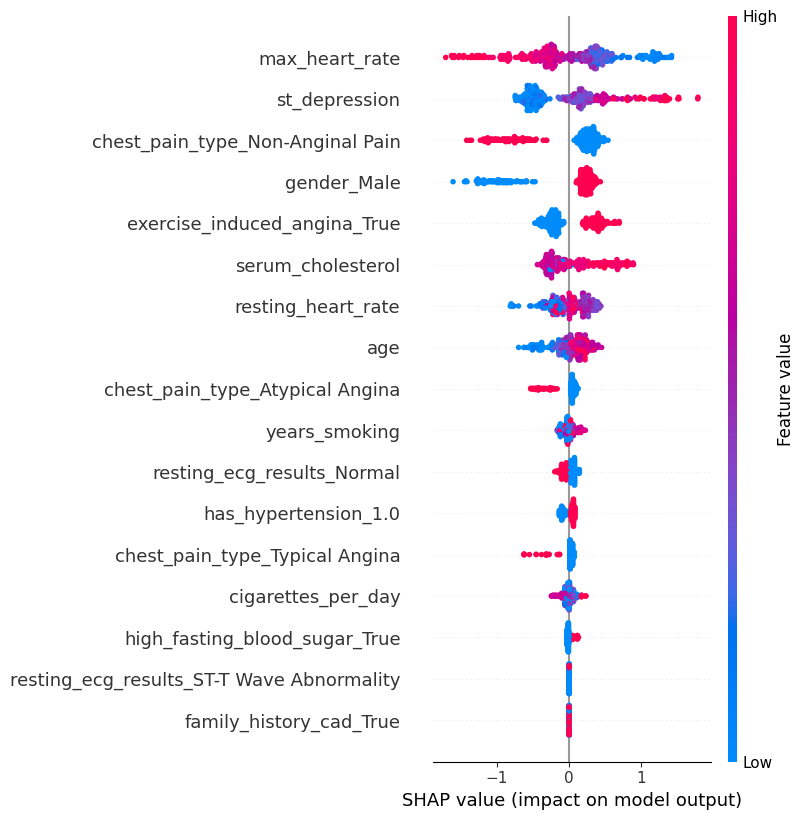

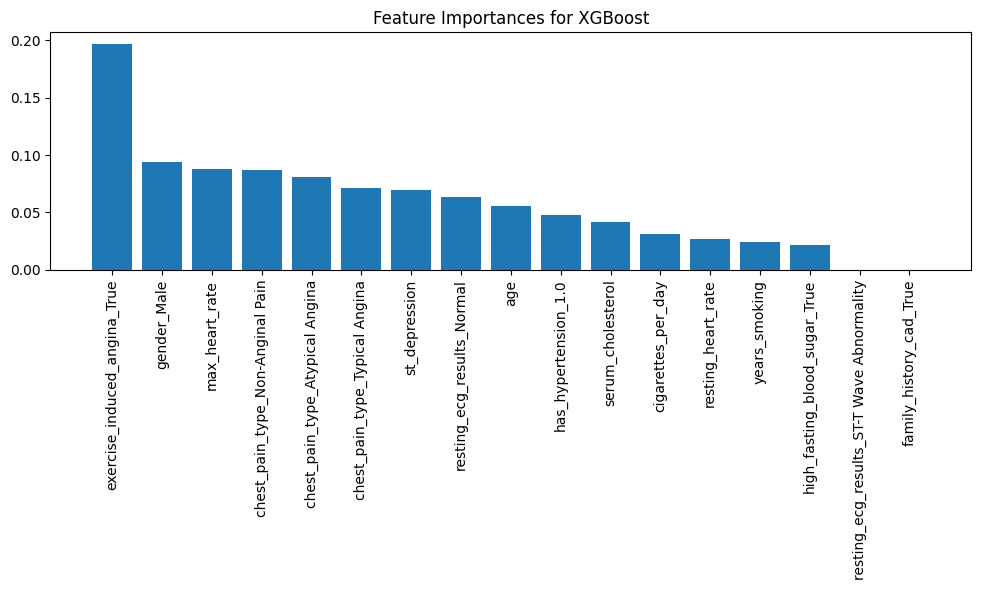

In [18]:
# Determine the best model
performance = performance[(performance.Model == "XGBoost") | (performance.Model == "Random Forest")]
best_model_name = performance.iloc[0]['Model']
print(f"\nThe best model is: {best_model_name}")

best_model = best_estimators[best_model_name]

# Initialize SHAP explainer
if best_model_name in ['Random Forest', 'XGBoost', 'Decision Tree', 'Gradient Boosting', 'AdaBoost', 'Extra Trees']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train)
elif best_model_name == 'Logistic Regression':
    explainer = shap.LinearExplainer(best_model, X_train)
    shap_values = explainer.shap_values(X_train)
elif best_model_name == 'Support Vector Machine':
    explainer = shap.KernelExplainer(best_model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_train, nsamples=100)
else:
    print(f"SHAP analysis not supported for {best_model_name}.")
    shap_values = None

# Plot SHAP summary plot if available
if shap_values is not None:
    shap.summary_plot(shap_values, features=X_train, feature_names=feature_names)

    # Feature Importance Plot
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # Plot the feature importances
        plt.figure(figsize=(10,6))
        plt.title(f'Feature Importances for {best_model_name}')
        plt.bar(range(len(importances)), importances[indices], align='center')
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
elif hasattr(best_model, 'coef_'):
    # For models with coefficients (e.g., Logistic Regression)
    coef = best_model.coef_[0]
    indices = np.argsort(abs(coef))[::-1]

    plt.figure(figsize=(10,6))
    plt.title(f'Feature Coefficients for {best_model_name}')
    plt.bar(range(len(coef)), coef[indices], align='center')
    plt.xticks(range(len(coef)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature importance not available for {best_model_name}.")